In [1]:
import scvelo as scv
import pandas
import matplotlib
import loompy as lp

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
matplotlib.rcParams['figure.dpi']= 300 # High quality graphs

In [63]:
wt = scv.read('/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/CellRanger_WT.loom', cache=True, index_col="CellID")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [79]:
ko = scv.read(filename='/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/CellRanger_MafKO.loom',
              cache=True,
              index_col="CellID")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
combined = scv.read('/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/combined.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [67]:
combined.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 9058 × 55401
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'>

In [6]:
adata = combined

In [71]:
# Read the corrected barcodes for the combined loom file
ko_bc = pandas.read_csv('/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/ko_corrected.barcodes.loom.csv', 
            index_col='x', 
            header=0)

wt_bc = pandas.read_csv('/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/wt_corrected.barcodes.loom.csv', 
            index_col='x', 
            header=0)

In [72]:
wt.obs['original.barcode'] = wt.obs.index
ko.obs['original.barcode'] = ko.obs.index

In [73]:
wt.obs.index = wt_bc.index
ko.obs.index = ko_bc.index

In [5]:
# Read the metadata to subset the loom file for cells in Seurat object
df = pandas.read_csv('/Volumes/Samsung_T5/JesusProject/LOOMs_MafKO/metadata.seurat.csv', 
            index_col='CellID', 
            header=0)

In [8]:
# Get the barcodes common between metadata and the scvelo object and subset by index
barcodes = adata.obs.index.tolist()
cells = df.index.tolist()
both = set(barcodes).intersection(cells)
ind = [barcodes.index(x) for x in both]

In [9]:
adata_subset = adata[ind,:]

In [11]:
ind2 = [cells.index(x) for x in both]
df_subset = df.loc[both]

In [14]:
# Add the relevant information from the metadata
adata_subset.obs['metadataCellID'] = df_subset.index # To check consistent cbind
adata_subset.obs['clusters'] = df_subset['seurat_clusters'].astype('category')
adata_subset.obs['cluster_names'] = df_subset['cluster_name'].astype('category')
adata_subset.obs['genotype'] = df_subset['Genotype'].astype('category')
adata_subset.obs['sample'] = df_subset['Sample'].astype('category')
adata_subset.obs['UMAP_1'] = df_subset['UMAP1']
adata_subset.obs['UMAP_2'] = df_subset['UMAP2']

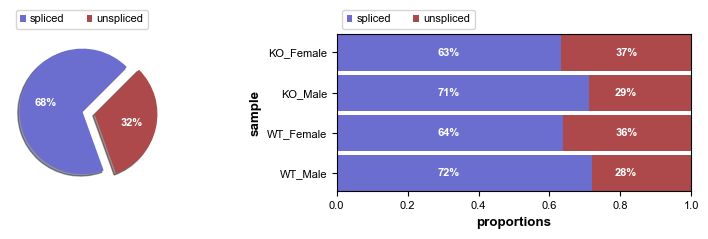

In [17]:
scv.pl.proportions(adata=adata_subset, groupby='sample')

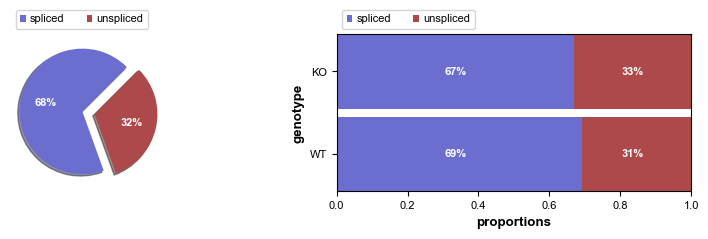

In [18]:
scv.pl.proportions(adata=adata_subset, groupby='genotype')

In [19]:
# Replace the UMAP coordinates for the ones in the Seurat object
umaps = ['UMAP_1','UMAP_2']
coords = adata_subset.obs[umaps]
adata_subset.obsm['X_umap'] = coords.values
adata_subset.obsm['X_umap']

array([[-11.14623191,  -2.38950939],
       [ -5.47882868,   1.20274554],
       [-10.06506659,  -1.33592649],
       ...,
       [ 10.91087888,   1.77797918],
       [ -7.20850922,   4.78082757],
       [ 11.69633172,   1.12071608]])

In [20]:
# Filter and normalize
scv.pp.filter_and_normalize(adata_subset, min_shared_counts=100, n_top_genes=2000)
scv.pp.moments(adata_subset, n_pcs=30, n_neighbors=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 46997 genes that are detected 100 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
# Recover gene dynamics
scv.tl.recover_dynamics(adata_subset)

recovering dynamics
    finished (1:29:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [22]:
scv.tl.velocity(adata_subset, mode='dynamical')
scv.tl.velocity_graph(adata_subset)

computing velocities
    finished (0:01:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:01:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [23]:
#adata_subset.write('path_to_folder/MafKO.h5ad') # Save the object

In [2]:
# adata_subset = scv.read('path_to_folder/MafKO.h5ad') # Load back the object

saving figure to file ./figures/scvelo_stream_all.svg


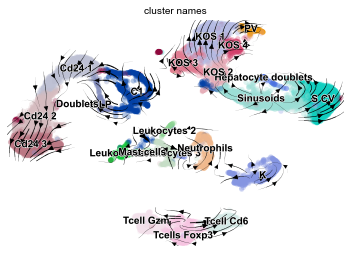

In [54]:
scv.pl.velocity_embedding_stream(adata_subset, basis='umap', color='cluster_names', min_mass=0, save = 'stream_all.svg')

In [27]:
scv.tl.latent_time(adata_subset)

computing terminal states
    identified 4 regions of root cells and 6 regions of end points .
    finished (0:00:08) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:26) --> added 
    'latent_time', shared time (adata.obs)


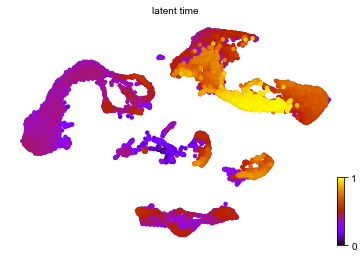

In [28]:
scv.pl.scatter(adata_subset, color='latent_time', color_map='gnuplot', size=80)

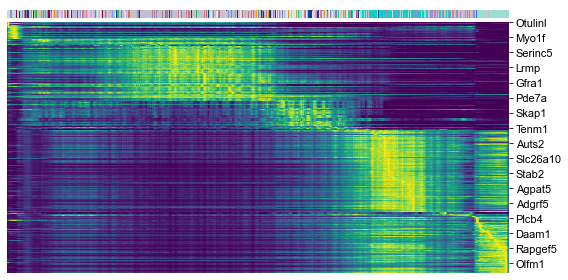

In [29]:
top_genes = adata_subset.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata_subset, var_names=top_genes, sortby='latent_time', n_convolve=100, col_color=['cluster_names'])

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


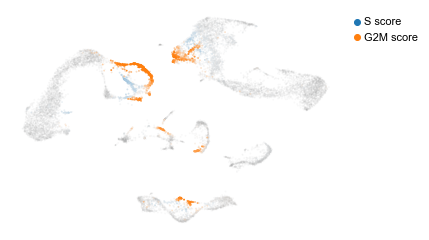

In [30]:
scv.tl.score_genes_cell_cycle(adata_subset)
scv.pl.scatter(adata_subset, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

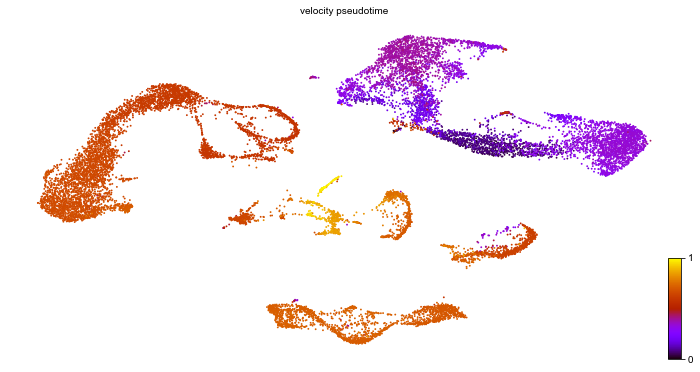

In [31]:
scv.tl.velocity_pseudotime(adata_subset)
scv.pl.scatter(adata_subset, color='velocity_pseudotime', cmap='gnuplot', figsize=(20,10))

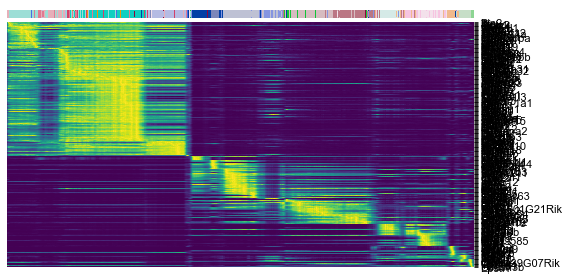

In [33]:
scv.pl.heatmap(adata_subset, var_names=top_genes, sortby='velocity_pseudotime', n_convolve=100, col_color=['cluster_names'],  yticklabels=True)

In [35]:
adata_subset.uns['neighbors']['distances'] = adata_subset.obsp['distances']
adata_subset.uns['neighbors']['connectivities'] = adata_subset.obsp['connectivities']

scv.tl.paga(adata_subset, groups='cluster_names')
df = scv.get_df(adata_subset, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:10) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


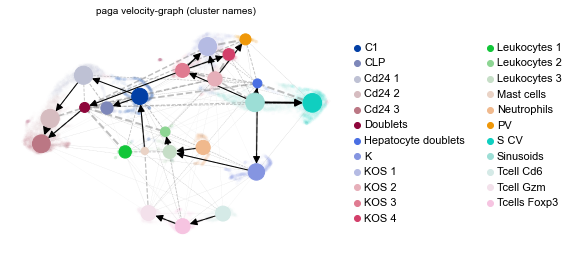

In [38]:
scv.pl.paga(adata_subset, basis='umap',color = 'cluster_names', size=50, alpha=.025,
            min_edge_width=1, node_size_scale=1.5)

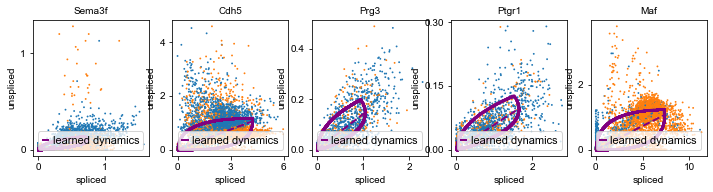

In [45]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=True)
scv.pl.scatter(adata_subset, basis=['Sema3f','Cdh5','Prg3','Ptgr1','Maf'], add_outline='fit_diff_kinetics', **kwargs, figsize= (20,20))

In [47]:
# Split by WT vs MUT
wt = adata_subset[adata_subset.obs['genotype']== 'WT']
ko = adata_subset[adata_subset.obs['genotype']== 'KO']

In [48]:
scv.tl.recover_dynamics(wt)
scv.tl.recover_dynamics(ko)

Trying to set attribute `.uns` of view, copying.


recovering dynamics


Trying to set attribute `.uns` of view, copying.


    finished (0:28:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:34:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [49]:
scv.pp.neighbors(wt)
scv.pp.neighbors(ko)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [50]:
scv.tl.velocity_graph(wt)
scv.tl.velocity_graph(ko)

computing velocity graph
    finished (0:00:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_stream_wt.svg


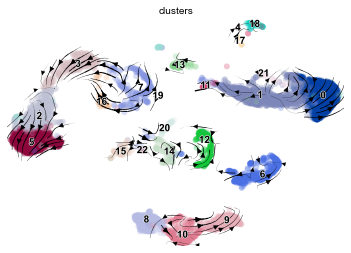

In [51]:
scv.pl.velocity_embedding_stream(wt, basis='umap', n_neighbors = 100, save = 'stream_wt.svg')

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_stream_ko.svg


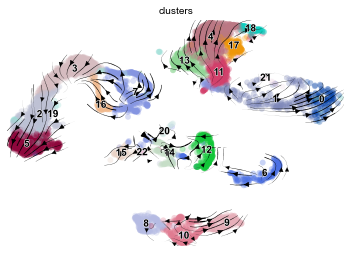

In [52]:
scv.pl.velocity_embedding_stream(ko, basis='umap', n_neighbors = 100, save = 'stream_ko.svg')

saving figure to file ./figures/scvelo_all.svg


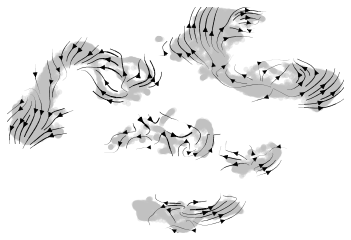

In [53]:
scv.pl.velocity_embedding_stream(adata_subset, basis='umap',color='#C1C1C1', n_neighbors = 100, save = 'all.svg')

In [3]:
# Subset for those clusters that belong to endothelial cell types
clusters_keep = [11,21,1,0,13,4,17,18]
adata_endo = adata_subset[adata_subset.obs.clusters.isin(clusters_keep)].copy()

In [5]:
# Split by WT vs MUT
wt = adata_endo[adata_endo.obs['genotype']== 'WT']
ko = adata_endo[adata_endo.obs['genotype']== 'KO']

Trying to set attribute `.uns` of view, copying.


recovering dynamics
... 3%WARNING: Fcgr3 not recoverable due to insufficient samples.
... 6%WARNING: Chil1 not recoverable due to insufficient samples.
... 13%WARNING: Ifng not recoverable due to insufficient samples.
... 23%WARNING: Trgv2 not recoverable due to insufficient samples.
... 25%WARNING: Trgc4 not recoverable due to insufficient samples.
... 30%WARNING: Olfm4 not recoverable due to insufficient samples.
... 32%WARNING: Gm34095 not recoverable due to insufficient samples.
... 36%WARNING: Itgb2l not recoverable due to insufficient samples.
... 42%WARNING: Trem1 not recoverable due to insufficient samples.
... 57%WARNING: Gm9733 not recoverable due to insufficient samples.
... 81%WARNING: Cd177 not recoverable due to insufficient samples.
... 81%WARNING: Mrgpra2b not recoverable due to insufficient samples.
... 86%WARNING: Cd209d not recoverable due to insufficient samples.
... 88%WARNING: Mcemp1 not recoverable due to insufficient samples.
... 97%WARNING: Tlr13 not recoverabl

Trying to set attribute `.uns` of view, copying.


    finished (0:07:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
... 6%WARNING: Cxcr2 not recoverable due to insufficient samples.
... 6%WARNING: Chil1 not recoverable due to insufficient samples.
... 11%WARNING: Upb1 not recoverable due to insufficient samples.
... 12%WARNING: Ifng not recoverable due to insufficient samples.
... 15%WARNING: Cd300lb not recoverable due to insufficient samples.
... 16%WARNING: Havcr1 not recoverable due to insufficient samples.
... 19%WARNING: Wfdc21 not recoverable due to insufficient samples.
... 30%WARNING: Olfm4 not recoverable due to insufficient samples.
... 36%WARNING: Itgb2l not recoverable due to insufficient samples.
... 37%WARNING: Csta2 not recoverable due to insufficient samples.
... 38%WARNING: Fpr1 not recoverable due to insufficient samples.
... 41%WARNING: Trem1 not recoverable due to insufficient samples.
... 42%WARNING: Ebi3 not recoverable due to insufficient samples.
... 46%W

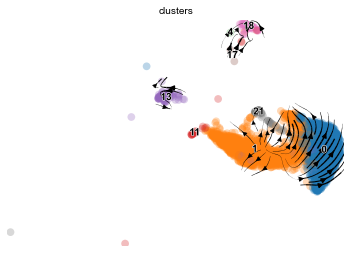

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_stream_ko_endo.svg


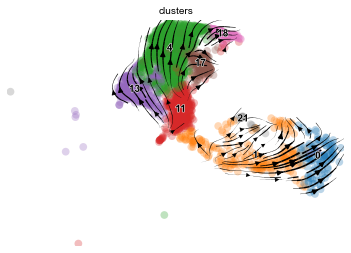

In [6]:
# Filter and normalize
scv.tl.recover_dynamics(wt)
scv.tl.recover_dynamics(ko)

scv.pp.neighbors(wt)
scv.pp.neighbors(ko)

scv.tl.velocity_graph(wt)
scv.tl.velocity_graph(ko)

scv.pl.velocity_embedding_stream(wt, basis='umap', n_neighbors = 100, save = 'stream_wt_endo.svg')
scv.pl.velocity_embedding_stream(ko, basis='umap', n_neighbors = 100, save = 'stream_ko_endo.svg')

In [7]:
# Paga graph abstraction for WT and MUT separately
wt.uns['neighbors']['distances'] = wt.obsp['distances']
wt.uns['neighbors']['connectivities'] = wt.obsp['connectivities']

scv.tl.paga(wt, groups='cluster_names')
df = scv.get_df(wt, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_wt_endo.svg


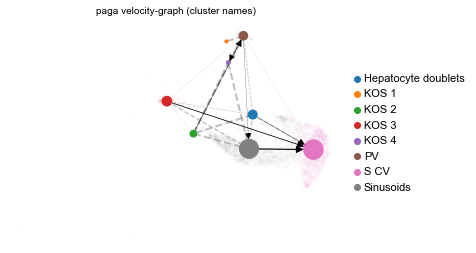

In [17]:
scv.pl.paga(wt, basis='umap',color = 'cluster_names', size=50, alpha=.025,
            min_edge_width=0, node_size_scale=0.5, save = 'paga_wt_endo.svg')

In [15]:
ko.uns['neighbors']['distances'] = ko.obsp['distances']
ko.uns['neighbors']['connectivities'] = ko.obsp['connectivities']

scv.tl.paga(ko, groups='cluster_names')
df = scv.get_df(ko, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_ko_endo.svg


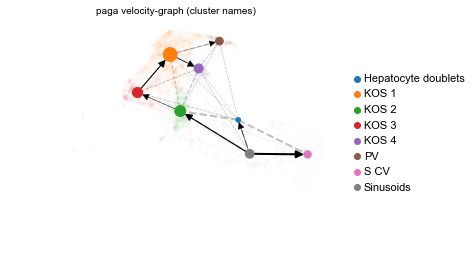

In [18]:
scv.pl.paga(ko, basis='umap',color = 'cluster_names', size=50, alpha=.025,
            min_edge_width=0, node_size_scale=0.5, save = 'paga_ko_endo.svg')

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_endo_all.svg


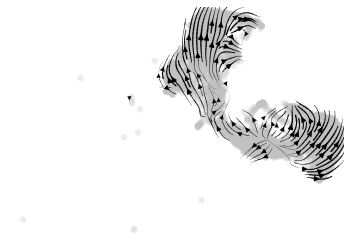

In [9]:
scv.pl.velocity_embedding_stream(adata_endo, basis='umap',color='#C1C1C1', n_neighbors = 100, save = 'endo_all.svg')

In [15]:
cluster_colors = ('#4292c6','#08519c','#fe9929','#ec7014','#fec44f','#cc4c02','#9ecae1','#8b3d2d')

saving figure to file ./figures/scvelo_stream_endo_all_clusters.svg


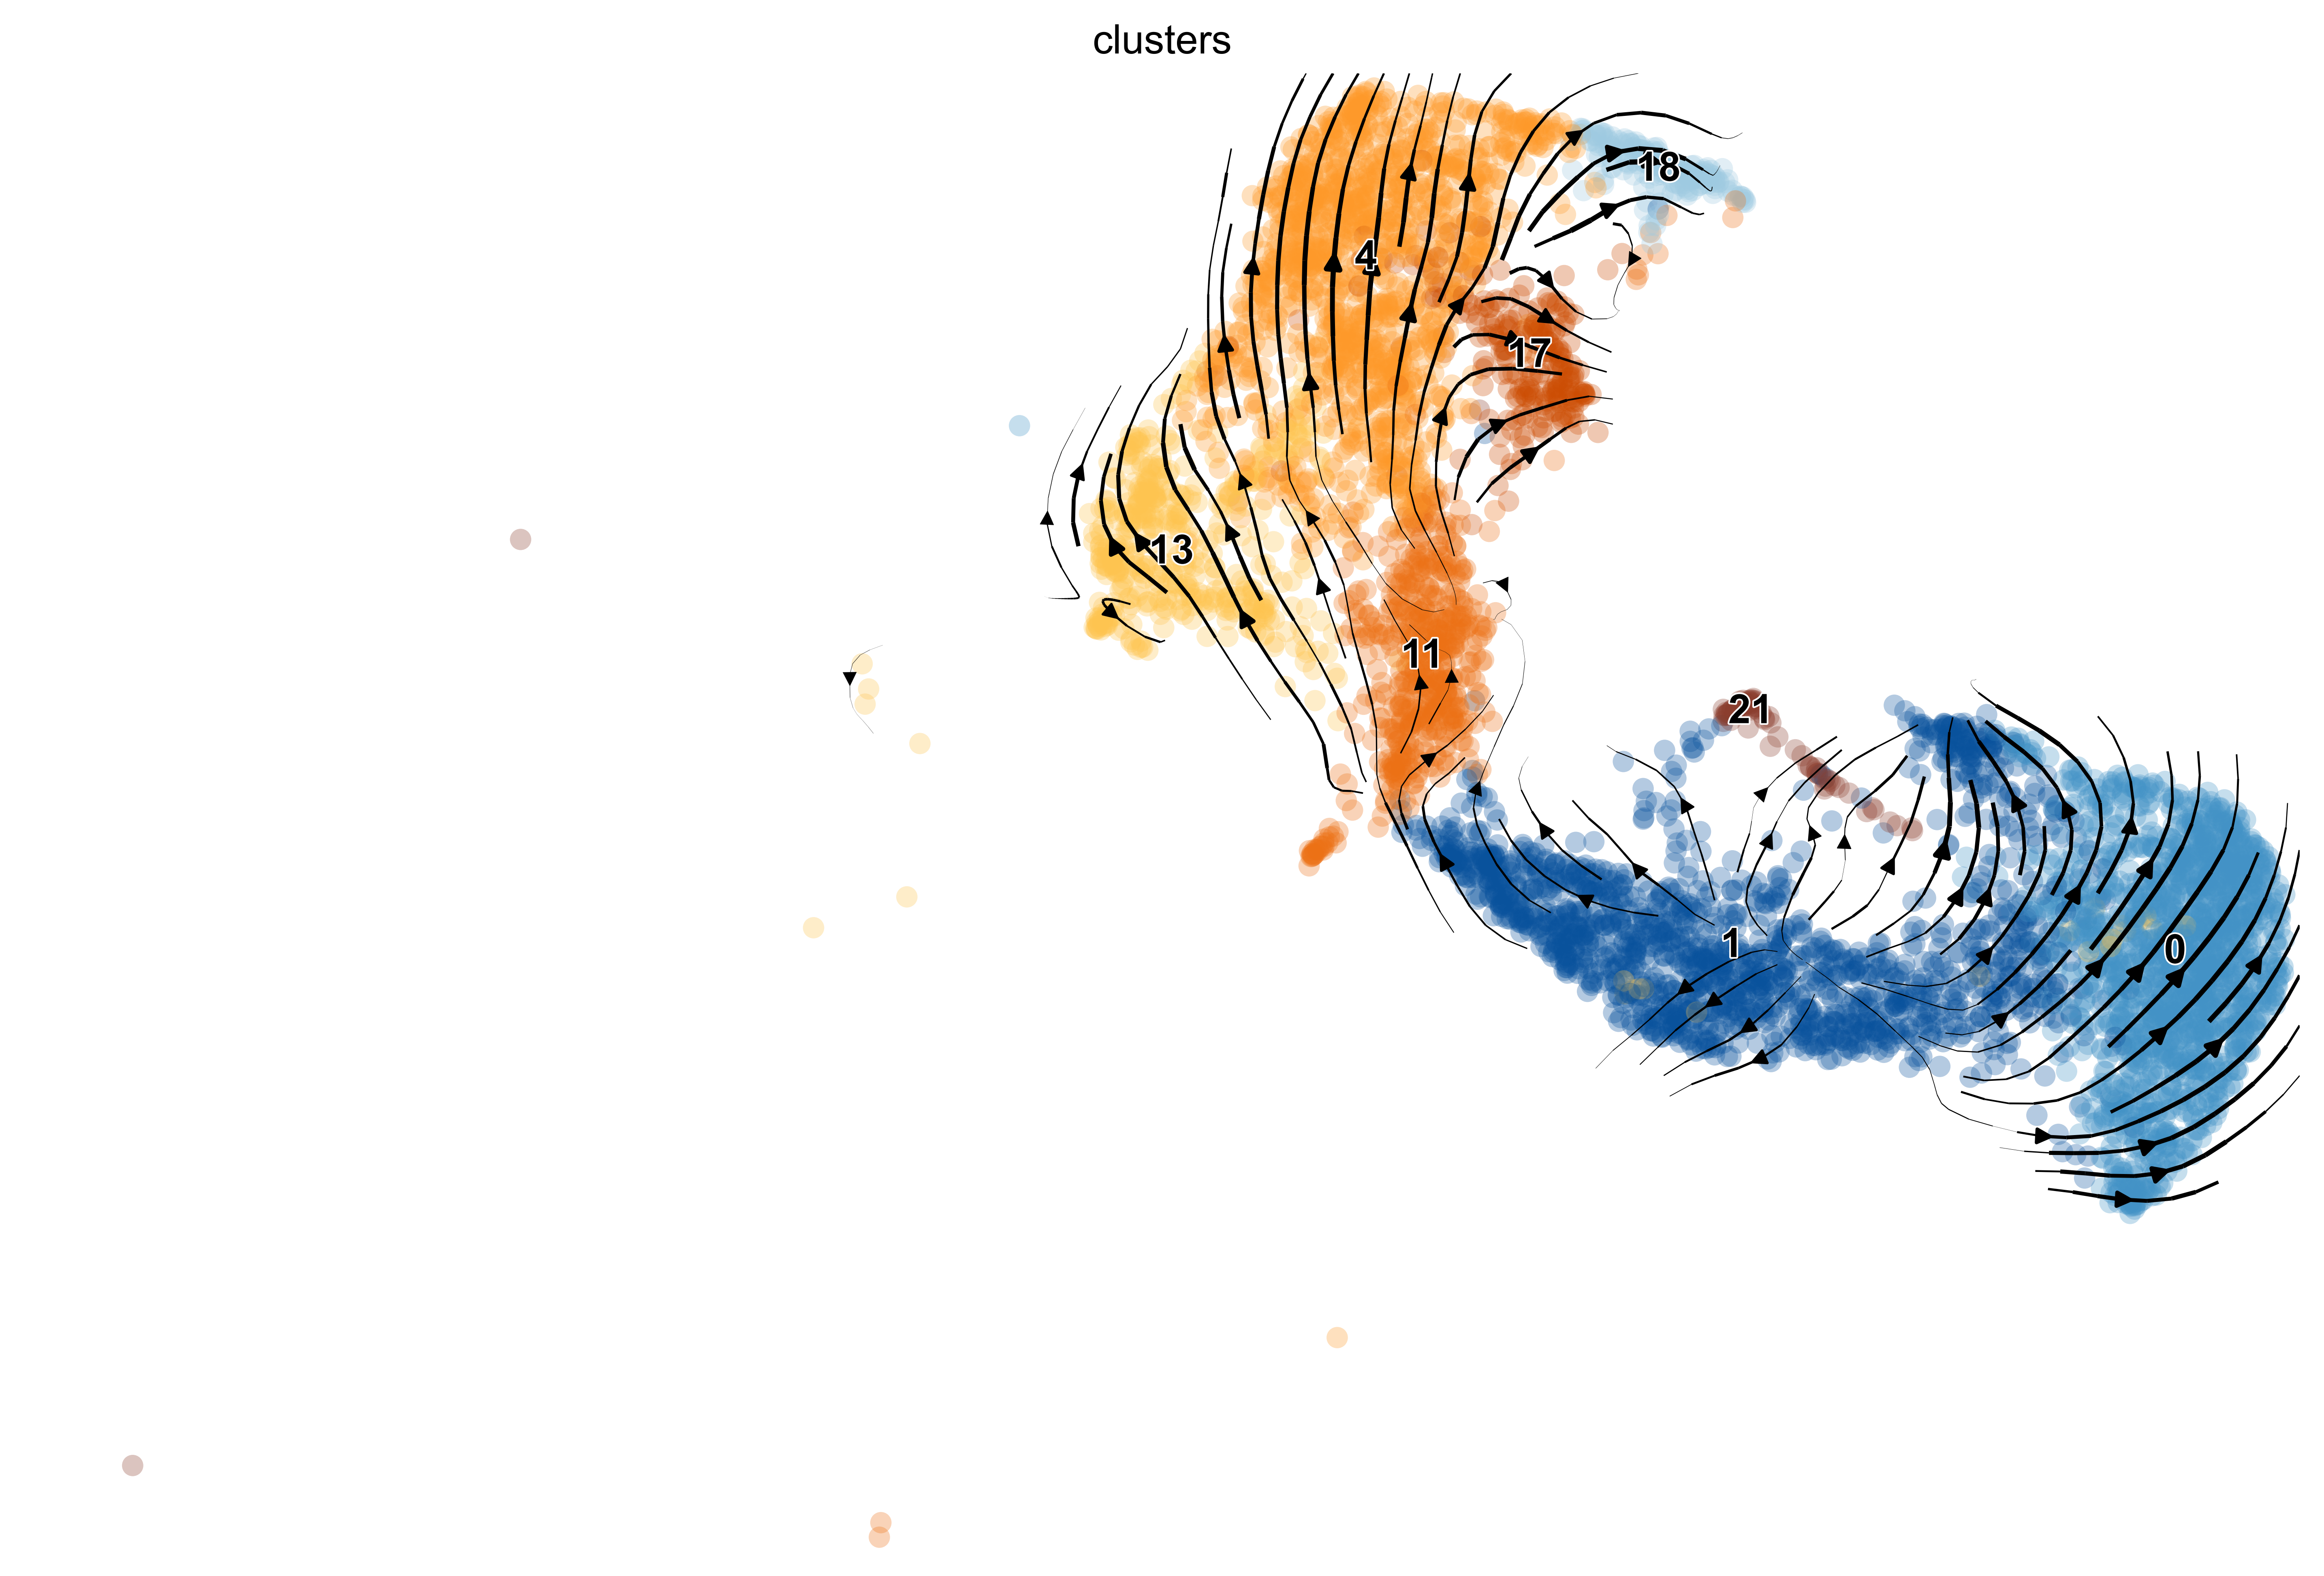

In [18]:
scv.pl.velocity_embedding_stream(adata_endo, basis='umap', n_neighbors = 100, palette=cluster_colors, save = 'stream_endo_all_clusters.svg')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file ./figures/scvelo_pseudotime_endo.svg


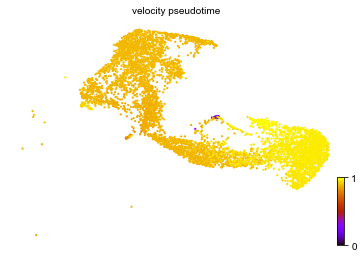

In [9]:
scv.tl.velocity_pseudotime(adata_endo)
scv.pl.scatter(adata_endo, color='velocity_pseudotime', cmap='gnuplot', save = 'pseudotime_endo.svg')

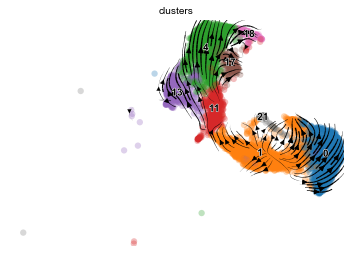

In [10]:
scv.pl.velocity_embedding_stream(adata_endo, basis='umap',palette=cluster_colors, save = 'subset_sinusoids_rightColor.svg')

In [116]:
import scipy
transition=scv.utils.get_transition_matrix(adata_endo)
df = pandas.DataFrame(data=scipy.sparse.csr_matrix.todense(transition))
df.to_csv('/Volumes/Samsung_T5/JesusProject/ProcessedData/Transitions_EndoOnly.csv', index=True)

In [13]:
top_genes = adata_endo.var['fit_likelihood'].sort_values(ascending=False).index[:300]

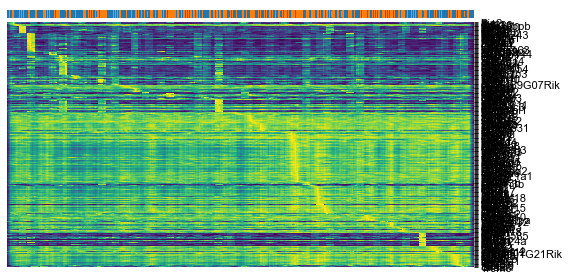

In [15]:
scv.pl.heatmap(adata_endo, var_names=top_genes, sortby='velocity_pseudotime', n_convolve=100, col_color=['genotype'],  yticklabels=True)

In [ ]:
scv.tl.differential_kinetic_test(adata_endo, var_names=var_names, groupby='genotype')

In [24]:
top_genes1 = wt.var['fit_likelihood'].sort_values(ascending=False).index[:300]
top_genes2 = ko.var['fit_likelihood'].sort_values(ascending=False).index[:300]
top_genes = top_genes1.union(top_genes2)

In [22]:
top_genes = top_genes1.union(top_genes2))